In [ ]:
path_cwd = '/content/drive/My Drive/Colab Notebooks/DU/data/'
path_logs = path_cwd + 'logs/'
path_models = path_cwd + 'models/'
path_root = '/content/drive/My Drive/Colab Notebooks/DU/data/'
path_zip = path_root + 'Coronahack-Chest-XRay-Dataset.zip'
path_unzip = path_root + 'Coronahack-Chest-XRay-Dataset/'
path_csv = path_unzip + 'Chest_xray_Corona_Metadata.csv'
path_train = path_unzip + 'Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/'
path_test = path_unzip + 'Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/'

In [ ]:
!rm -rf '{path_unzip}'
!unzip '{path_zip}' -d '{path_unzip}'

In [ ]:
import time
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.python.util.deprecation as deprecation
import matplotlib.pyplot as plt
from collections import Counter
from keras.models import Sequential
from keras.layers import *
from keras.applications import ResNet50
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras import regularizers
from keras.models import load_model
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy.stats import mode

In [ ]:
%load_ext tensorboard
deprecation._PRINT_DEPRECATION_WARNINGS = False
pd.options.mode.chained_assignment = None

In [ ]:
class Dataset:
    def __init__(self, classes, shape=(64, 64)):
        self.shape = shape
        self.classes = classes
        self.class_trans = {}
        for i, c in enumerate(self.classes):
            self.class_trans[c], self.class_trans[i] = i, c


    def load(self):
        df = pd.read_csv(path_csv)
        df = df.drop(columns=['Unnamed: 0', 'Label_1_Virus_category', 'Label_2_Virus_category'])
        df = df.rename(columns={'X_ray_image_name':'x', 'Label':'y'})

        train_mask = df['Dataset_type'] == 'TRAIN'
        self.xy_train, self.xy_test = df[train_mask], df[~train_mask]

        self.xy_train['x'] = path_train + self.xy_train['x']
        self.xy_test['x'] = path_test + self.xy_test['x']

        self.y_test = self.xy_test['y'].apply(lambda x: self.class_trans[x])

In [ ]:
class Model:
    def __init__(self, data, epochs=16, batch_size=32):
        self.data = data
        self.epochs = epochs
        self.batch_size = batch_size


    def build(self):
        self.model = self._build()
        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


    def fit(self):
        class_weights = class_weight.compute_class_weight('balanced', self.data.classes, self.data.xy_train['y'])
        class_weights = dict(zip(range(len(self.data.classes)), class_weights))

        callbacks = [EarlyStopping(patience=2, restore_best_weights=True), TensorBoard(path_logs)]

        train_flow = self._flow(self._train_gen(), self.data.xy_train)
        test_flow = self._flow(self._test_gen(), self.data.xy_test)

        return self.model.fit_generator(
            train_flow,
            epochs=self.epochs,
            callbacks=callbacks,
            validation_data=test_flow,
            class_weight=class_weights)


    def save(self):
        self.model.save(path_models + type(self).__name__)


    def load(self):
        self.model = load_model(path_models + type(self).__name__)


    def predict(self):
        test_flow = self._flow(self._test_gen(), self.data.xy_test, shuffle=False)
        y_pred = self.model.predict_generator(test_flow) > 0.5

        cr = classification_report(self.data.y_test, y_pred, target_names=self.data.classes)
        print(cr)

        cm = confusion_matrix(self.data.y_test, y_pred)
        plt.matshow(cm)
        plt.colorbar()
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        x_test, y_test = self.data.xy_test['x'].values.tolist(), self.data.xy_test['y'].values.tolist()
        y_pred = [self.data.class_trans[y] for y in y_pred.flatten()]

        return x_test, y_test, y_pred


    def _train_gen(self):
        return ImageDataGenerator(
            rotation_range=15,
            zoom_range=0.25,
            rescale=1.0/255.0)


    def _test_gen(self):
        return ImageDataGenerator(rescale=1.0/255.0)


    def _flow(self, generator, dataframe, shuffle=True):
        return generator.flow_from_dataframe(
            dataframe=dataframe,
            x_col='x',
            y_col='y',
            target_size=self.data.shape,
            batch_size=self.batch_size,
            class_mode='binary',
            shuffle=shuffle)

In [ ]:
class Ensemble:
    def __init__(self, models):
        self.models = models


    def fit(self):
        for i, model in enumerate(self.models):
            model.build()
            history = model.fit()
            self._plot(history, len(self.models), i)
            model.save()


    def predict(self):
        preds = []

        for model in self.models:
            model.load()
            preds.append(model.predict())

        return preds


    def _plot(self, history, model_total, model_index):
        plt.subplots(figsize=(24, 24))

        plt.subplot(model_total, 2, 2 * model_index + 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'])

        plt.subplot(model_total, 2, 2 * model_index + 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'])

In [ ]:
class MyLeNet5(Model):
    def _build(self):
        model = Sequential()
        model.add(Conv2D(32, 3, activation='relu', input_shape=self.data.shape + (3, )))
        model.add(MaxPool2D(2))
        model.add(Conv2D(48, 3, activation='relu'))
        model.add(MaxPool2D(2))
        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(Dense(84, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        return model


class MyAlexNet(Model):
    def _build(self):
        model = Sequential()
        model.add(Conv2D(32, 5, strides=4, activation='relu', input_shape=self.data.shape + (3, )))
        model.add(MaxPool2D(3, 2))
        model.add(Conv2D(256, 5, padding='same', activation='relu'))
        model.add(MaxPool2D(3, 2))
        model.add(Conv2D(384, 3, padding='same', activation='relu'))
        model.add(Conv2D(384, 3, padding='same', activation='relu'))
        model.add(Conv2D(256, 3, padding='same', activation='relu'))
        model.add(MaxPool2D(3, 2))
        model.add(Flatten())
        model.add(Dense(4096, activation='selu', kernel_initializer='lecun_normal'))
        model.add(Dense(4096, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        return model


class MyVGG16(Model):
    def _build(self):
        base = VGG16(include_top=False, input_shape=self.data.shape + (3, ))
        base.trainable = False
        model = Sequential()
        model.add(base)
        model.add(Flatten())
        model.add(Dropout(0.2))
        model.add(Dense(1, activation='sigmoid'))
        return model

In [ ]:
!rm -rf '{path_logs}' '{path_models}'
!mkdir '{path_logs}' '{path_models}'

Found 5286 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.
Epoch 1/16
166/166 [==============================] - 106s 641ms/step - loss: 0.4580 - accuracy: 0.7533 - val_loss: 0.4731 - val_accuracy: 0.7804
Epoch 2/16
166/166 [==============================] - 112s 673ms/step - loss: 0.3006 - accuracy: 0.8721 - val_loss: 0.2711 - val_accuracy: 0.8894
Epoch 3/16
166/166 [==============================] - 105s 631ms/step - loss: 0.2458 - accuracy: 0.8975 - val_loss: 0.2671 - val_accuracy: 0.8846
Epoch 4/16
166/166 [==============================] - 106s 638ms/step - loss: 0.2400 - accuracy: 0.8984 - val_loss: 0.2593 - val_accuracy: 0.8942
Epoch 5/16
166/166 [==============================] - 108s 649ms/step - loss: 0.2032 - accuracy: 0.9154 - val_loss: 0.2743 - val_accuracy: 0.9038
Epoch 6/16
166/166 [==============================] - 105s 630ms/step - loss: 0.2023 - accuracy: 0.9162 - val_loss: 0.2807 - val_accuracy: 0.8974
INF

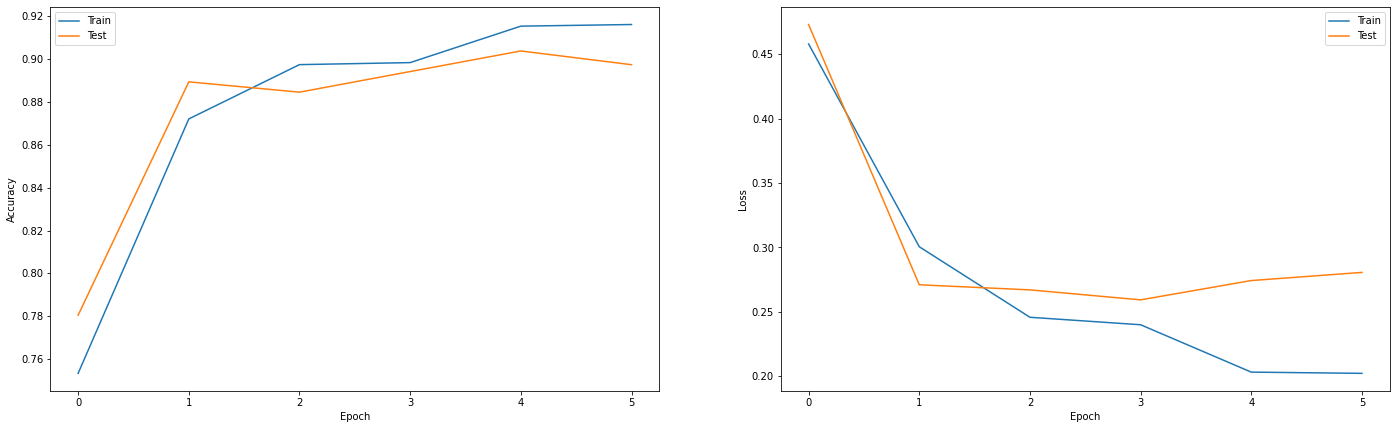

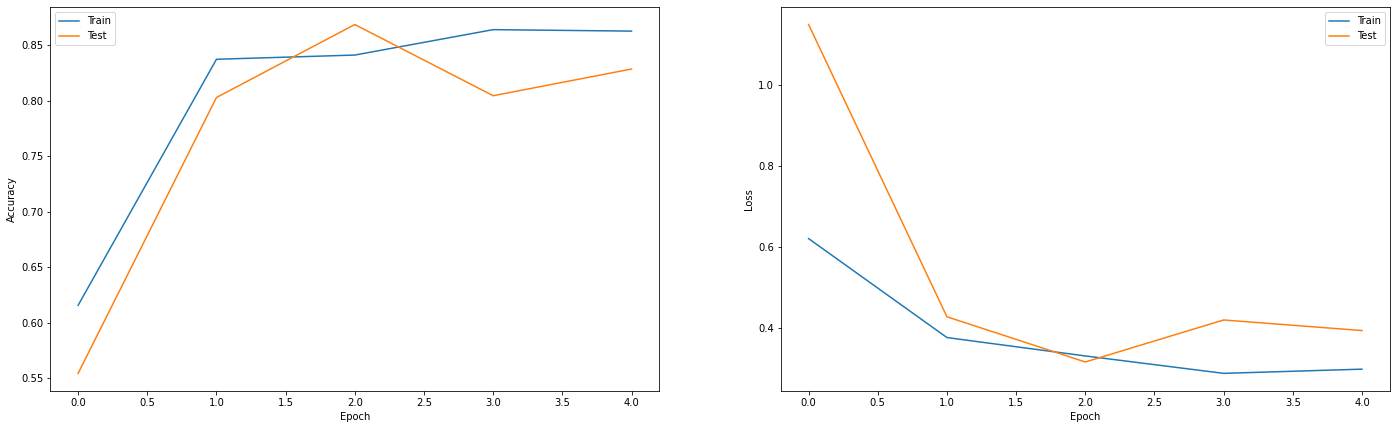

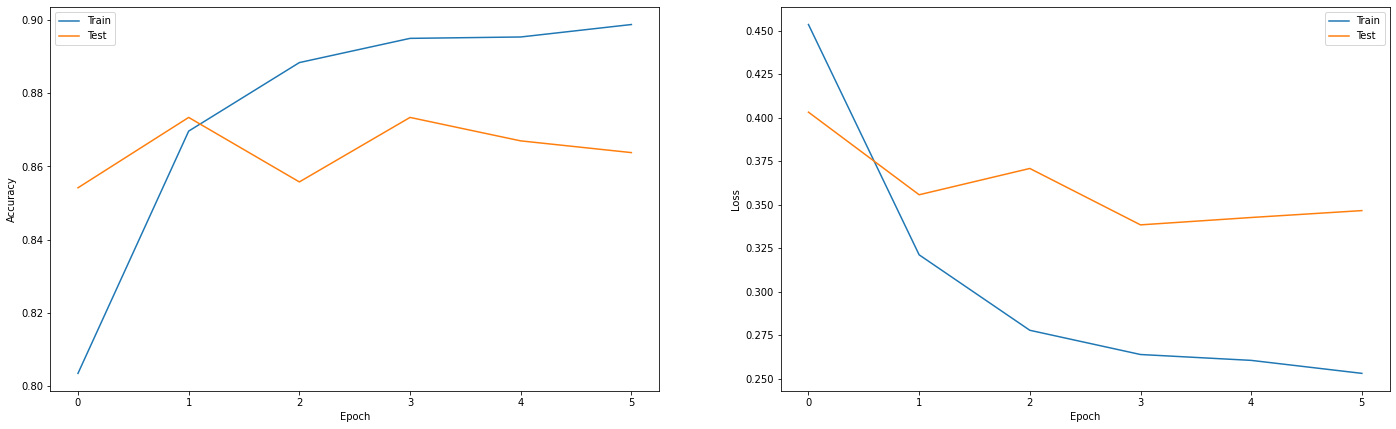

In [ ]:
%%time

dataset = Dataset(['Normal', 'Pnemonia'])
dataset.load()

models = []
models.append(MyLeNet5(dataset))
models.append(MyAlexNet(dataset))
models.append(MyVGG16(dataset))

ensemble = Ensemble(models)
ensemble.fit()

In [ ]:
%tensorboard --logdir '{path_logs}'

Found 624 validated image filenames belonging to 2 classes.
              precision    recall  f1-score   support

      Normal       0.85      0.87      0.86       234
    Pnemonia       0.92      0.91      0.91       390

    accuracy                           0.89       624
   macro avg       0.89      0.89      0.89       624
weighted avg       0.89      0.89      0.89       624



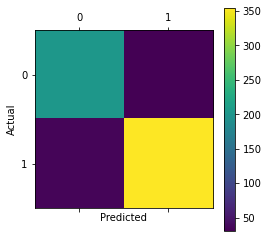

Found 624 validated image filenames belonging to 2 classes.
              precision    recall  f1-score   support

      Normal       0.83      0.82      0.82       234
    Pnemonia       0.89      0.90      0.90       390

    accuracy                           0.87       624
   macro avg       0.86      0.86      0.86       624
weighted avg       0.87      0.87      0.87       624



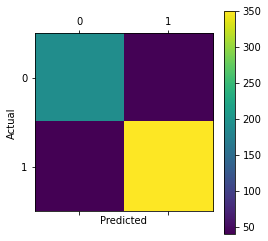

Found 624 validated image filenames belonging to 2 classes.
              precision    recall  f1-score   support

      Normal       0.79      0.89      0.84       234
    Pnemonia       0.93      0.86      0.89       390

    accuracy                           0.87       624
   macro avg       0.86      0.88      0.87       624
weighted avg       0.88      0.87      0.87       624



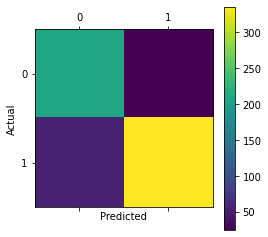

Predicted=Normal	Actual=Normal	Probability=3/3
Predicted=Normal	Actual=Normal	Probability=3/3
Predicted=Normal	Actual=Normal	Probability=3/3
Predicted=Normal	Actual=Normal	Probability=3/3
Predicted=Normal	Actual=Normal	Probability=2/3
Predicted=Normal	Actual=Normal	Probability=3/3
Predicted=Normal	Actual=Normal	Probability=3/3
Predicted=Normal	Actual=Normal	Probability=3/3
Predicted=Normal	Actual=Normal	Probability=3/3
Predicted=Normal	Actual=Normal	Probability=3/3
Predicted=Normal	Actual=Normal	Probability=3/3
Predicted=Normal	Actual=Normal	Probability=3/3
Predicted=Normal	Actual=Normal	Probability=3/3
Predicted=Normal	Actual=Normal	Probability=3/3
Predicted=Normal	Actual=Normal	Probability=2/3
Predicted=Normal	Actual=Normal	Probability=3/3
Predicted=Pnemonia	Actual=Normal	Probability=2/3
Predicted=Normal	Actual=Normal	Probability=3/3
Predicted=Pnemonia	Actual=Normal	Probability=2/3
Predicted=Normal	Actual=Normal	Probability=3/3
Predicted=Normal	Actual=Normal	Probability=3/3
Predicted

In [ ]:
%%time

dataset = Dataset(['Normal', 'Pnemonia'])
dataset.load()

models = []
models.append(MyLeNet5(dataset))
models.append(MyAlexNet(dataset))
models.append(MyVGG16(dataset))

ensemble = Ensemble(models)
preds = ensemble.predict()

preds = np.transpose(preds)
acc = 0

for pred in preds:
    counts = Counter([p for p in pred[2]])
    p, prob = counts.most_common(1)[0][0], sum(counts.values())
    acc += 1 if p == pred[1][0] else 0
    print("Predicted={}\tActual={}\tProbability={}/{}".format(p, pred[1][0], counts[p], prob))

print("Accuracy={}".format(acc/len(preds)))